Exercício 1 - Lista Final - Fundamentos de Redes Neurais e Aprendizado Estatístico


In [38]:
from tensorflow.keras.datasets import cifar100
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import cv2

np.random.seed(42) # setando semente

Carregar o dataset CIFAR-100

In [39]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Concatenando os dados

In [40]:
# Concatenar as imagens de treinamento e teste
x_all = np.concatenate((x_train, x_test), axis=0)

# Concatenar os rótulos de treinamento e teste
y_all = np.concatenate((y_train, y_test), axis=0)

Selecionar duas classes específicas para um problema binário

In [41]:
classes_to_select = [47, 98]  # Índices de 'tree' e 'woman'
train_indices = np.isin(y_train, classes_to_select).flatten()
test_indices = np.isin(y_test, classes_to_select).flatten()

In [42]:
x_train, y_train = x_train[train_indices], y_train[train_indices]
x_test, y_test = x_test[test_indices], y_test[test_indices]

Plotando o conjunto de dados escolhidos

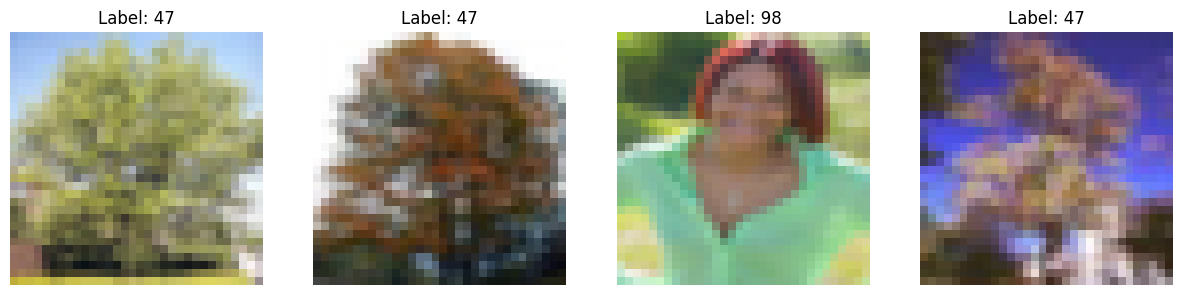

In [43]:
# Define o número de imagens que você quer plotar
num_images = 4

# Define o tamanho da figura
plt.figure(figsize=(15, 5))

# Plota as imagens do conjunto de treinamento
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')

plt.show()

Convertendo as imagens para escala de cinza

In [44]:
x_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_train])
x_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_test])

Plotando o conjunto de dados em escala de cinza

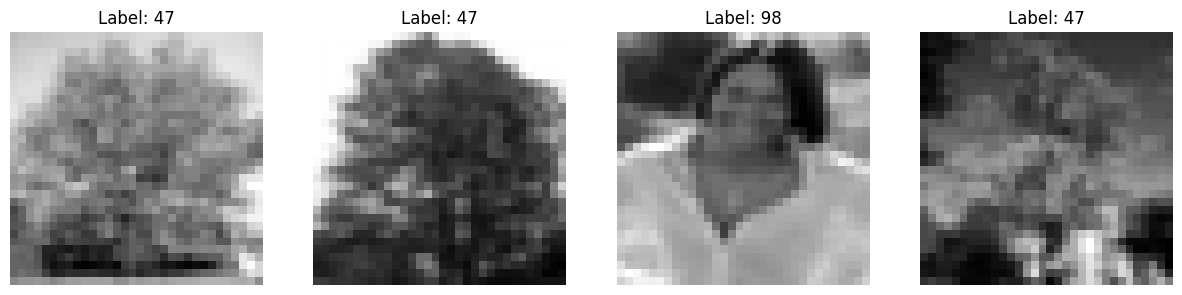

In [45]:
num_images = 4

# Define o tamanho da figura
plt.figure(figsize=(15, 5))

# Plota as imagens do conjunto de treinamento em escala de cinza
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_train_gray[i], cmap='gray')
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')

plt.show()

Vetorização das imagens em escala de cinza
Cada imagem de 32x32 (dimensão do CIFAR-100) será convertida em um vetor de 1024 elementos (32*32)


In [46]:
x_train_gray_flattened = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_gray_flattened = x_test_gray.reshape(x_test_gray.shape[0], -1)

# Verificando as formas das novas matrizes
print(f'Formato de x_train_gray_flattened: {x_train_gray_flattened.shape}')
print(f'Formato de x_test_gray_flattened: {x_test_gray_flattened.shape}')

Formato de x_train_gray_flattened: (1000, 1024)
Formato de x_test_gray_flattened: (200, 1024)


Verificando os formatos de todos os dados

In [47]:
data_shapes = {
    "x_train original": x_train.shape,
    "x_train gray": x_train_gray.shape,
    "x_train gray flattened": x_train_gray_flattened.shape,
    "y_train": y_train.shape,
    "x_test original": x_test.shape,
    "x_test gray": x_test_gray.shape,
    "x_test gray flattened": x_test_gray_flattened.shape,
    "y_test": y_test.shape
}

data_shapes

{'x_train original': (1000, 32, 32, 3),
 'x_train gray': (1000, 32, 32),
 'x_train gray flattened': (1000, 1024),
 'y_train': (1000, 1),
 'x_test original': (200, 32, 32, 3),
 'x_test gray': (200, 32, 32),
 'x_test gray flattened': (200, 1024),
 'y_test': (200, 1)}

Escalando os dados

In [48]:
scaler = StandardScaler()

# Ajustar e transformar os dados de treino
x_train_gray_scaled = scaler.fit_transform(x_train_gray_flattened)

# Apenas transformar os dados de teste
x_test_gray_scaled = scaler.transform(x_test_gray_flattened)

Dividir o conjunto de dados escalonados em conjunto de treino e teste

In [49]:
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(
    x_train_gray_scaled,  # Dados de entrada (features)
    y_train,              # Labels para o conjunto de treino
    test_size=0.2,        # Proporção do conjunto de teste (80% treino, 20% teste)
    random_state=42,      # Semente para garantir reprodutibilidade
    shuffle=True          # Embaralhar os dados
)

# Verificando as formas dos novos conjuntos
print(f'Formato de x_train_final: {x_train_final.shape}')
print(f'Formato de x_test_final: {x_test_final.shape}')
print(f'Formato de y_train_final: {y_train_final.shape}')
print(f'Formato de y_test_final: {y_test_final.shape}')

Formato de x_train_final: (800, 1024)
Formato de x_test_final: (200, 1024)
Formato de y_train_final: (800, 1)
Formato de y_test_final: (200, 1)


Função para plotar o histograma

In [50]:
def plot_gray_histogram(data, title='Histograma de Escala de Cinza'):
    plt.figure(figsize=(10, 5))
    plt.hist(data.flatten(), bins=256, range=(0, 255), color='blue', alpha=0.75)
    plt.title(title)
    plt.xlabel('Valor do Pixel')
    plt.ylabel('Número de Pixels')
    plt.show()

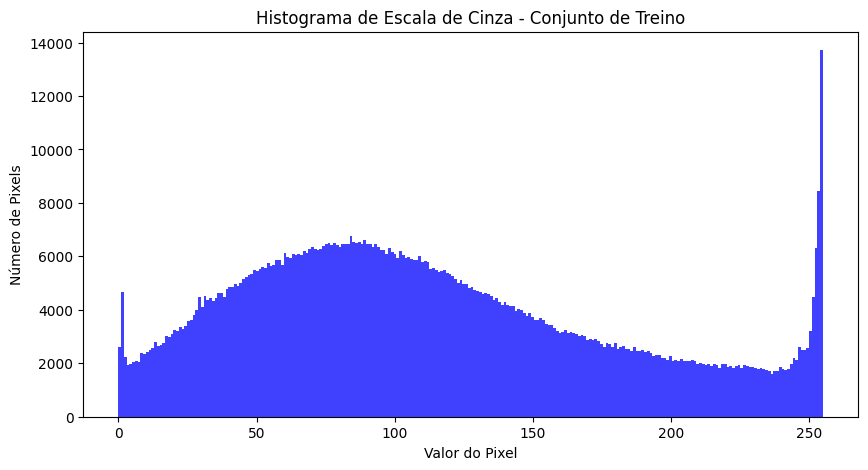

In [51]:
# Plotar histograma para o conjunto de treino
plot_gray_histogram(x_train_gray_flattened, title='Histograma de Escala de Cinza - Conjunto de Treino')

Função para contar e plotar o número de imagens por classe

In [52]:
def plot_class_distribution(ax, labels, title='Distribuição de Imagens por Classe'):
    unique, counts = np.unique(labels, return_counts=True)
    bar_width = 40.0
    ax.bar(unique, counts, width=bar_width, color=['purple', 'grey'])  # Ajuste as cores conforme necessário
    ax.set_xticks(unique)  # Ajuste os rótulos no eixo x
    ax.set_title(title)
    ax.set_xlabel('Classe')
    ax.set_ylabel('Número de Imagens')

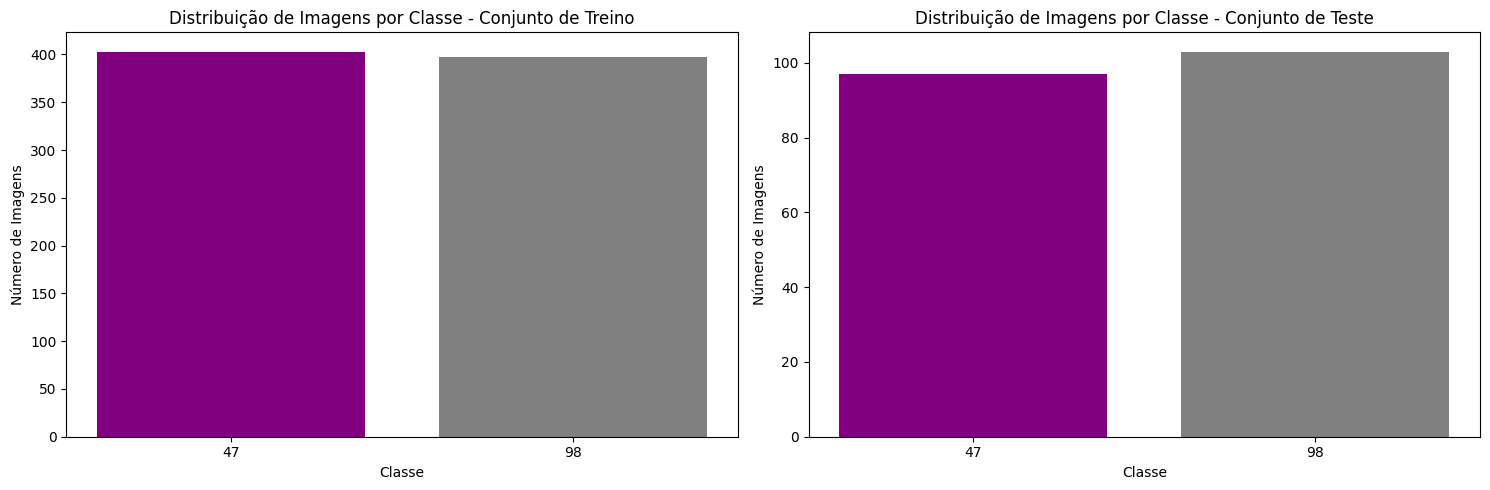

In [53]:
# Criar a figura e os eixos para os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotar distribuição para o conjunto de treino e de teste
plot_class_distribution(ax1, y_train_final, title='Distribuição de Imagens por Classe - Conjunto de Treino')
plot_class_distribution(ax2, y_test_final, title='Distribuição de Imagens por Classe - Conjunto de Teste')

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()


In [54]:
x_train_final

array([[ 0.12385599,  0.23301726,  0.06024546, ..., -1.36329964,
        -1.34470499, -1.37051421],
       [-0.32286286, -0.50063186, -1.19325302, ..., -0.00821609,
        -0.14145923, -0.28116406],
       [ 1.22150804,  1.22408711,  1.22328529, ..., -0.45040125,
        -0.45288755, -0.47668845],
       ...,
       [ 1.22150804,  1.19834504,  1.21036263, ...,  2.06006934,
         2.02438313,  2.00926444],
       [ 0.46846768,  0.46469592,  0.4866934 , ..., -1.43461983,
        -1.41548415, -1.41241229],
       [ 0.83860616,  0.09143585, -0.05605852, ...,  1.71773245,
         1.57139649,  1.52045348]])

Aplicando o KPCA no conjunto de dados selecionados

In [55]:
# Inicializar o KernelPCA
kpca = KernelPCA(n_components=200, kernel='poly', gamma=0.01)  # Ajuste gamma e n_components conforme necessário

# Aplicar KPCA aos dados de treino e teste
x_train_kpca = kpca.fit_transform(x_train_final)
x_test_kpca = kpca.transform(x_test_final)

# Verificar as formas das novas matrizes
print(f'Formato de x_train_kpca: {x_train_kpca.shape}')
print(f'Formato de x_test_kpca: {x_test_kpca.shape}')

Formato de x_train_kpca: (800, 200)
Formato de x_test_kpca: (200, 200)


In [56]:
# Calcular a variância para cada componente principal (ao longo das colunas)
explained_variance = np.var(x_train_kpca, axis=0)

# Normalizar para obter a proporção da variância explicada
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Variância explicada cumulativa
explained_variance_cumulative = np.cumsum(explained_variance_ratio)

In [57]:
autovalores = kpca.eigenvalues_

explained_variance_ratio = autovalores / np.sum(autovalores)

explained_variance_cumulative = np.cumsum(explained_variance_ratio)

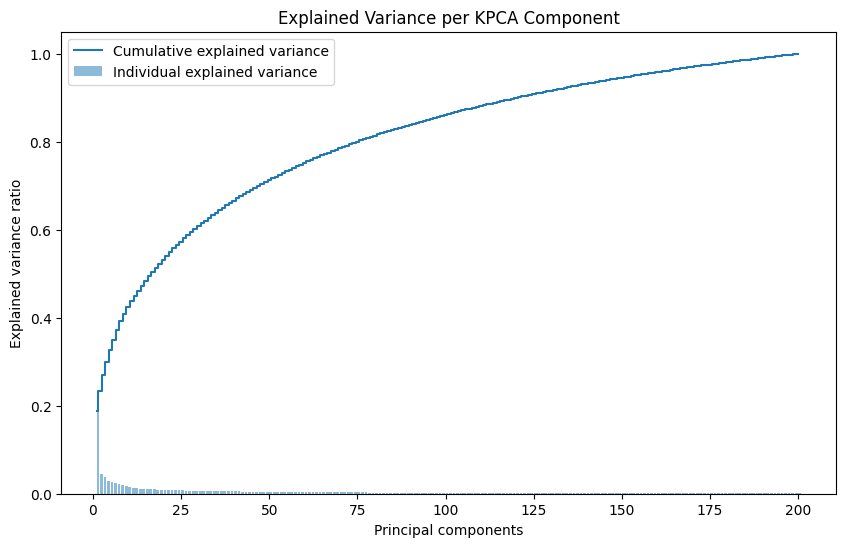

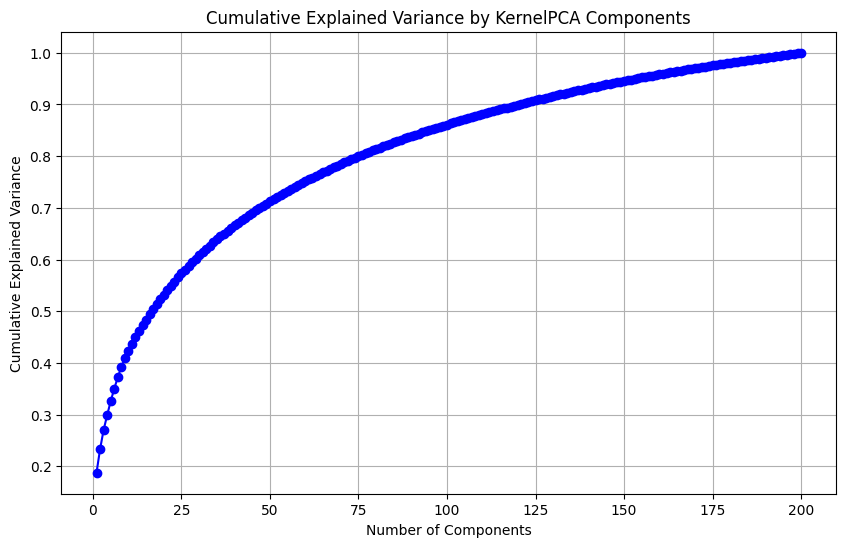

In [58]:
# Gráficos
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='edge',
        label='Individual explained variance')
plt.step(range(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance per KPCA Component')
plt.show()

# Gráfico de linha da variância explicada cumulativa
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by KernelPCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Visualição dos resultados

In [59]:
def plot_kpca(x, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), cmap='viridis', s=10)
    plt.colorbar(scatter, label='Classe')
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

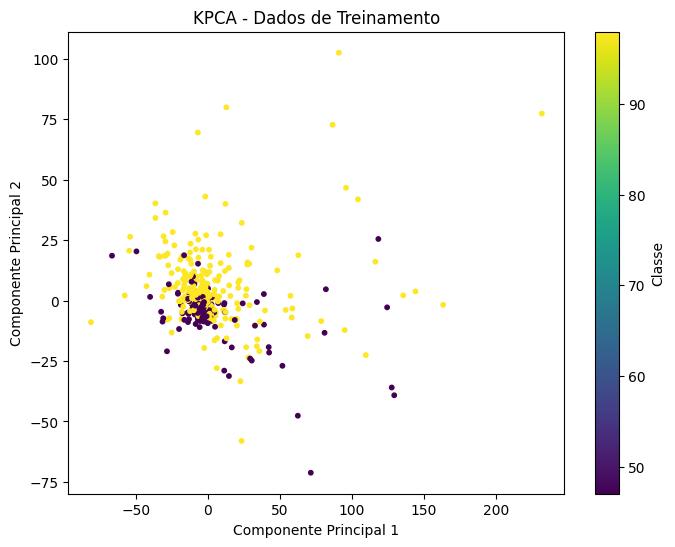

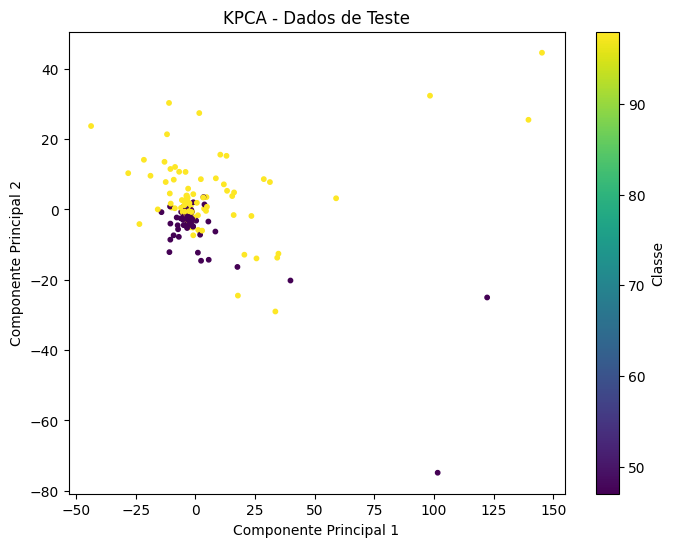

In [60]:
# Plotar os resultados usando a função plot_kpca
plot_kpca(x_train_kpca, y_train_final, 'KPCA - Dados de Treinamento')
plot_kpca(x_test_kpca, y_test_final, 'KPCA - Dados de Teste')

In [61]:
# Verificar se x_train_kpca e y_train têm o mesmo número de amostras
print(f"Shape de x_train_kpca: {x_train_kpca.shape}")
print(f"Shape de y_train: {y_train_final.shape}")

if x_train_kpca.shape[0] == y_train_final.shape[0]:
    print("x_train_kpca e y_train têm o mesmo número de amostras.")
else:
    print("x_train_kpca e y_train NÃO têm o mesmo número de amostras.")

Shape de x_train_kpca: (800, 200)
Shape de y_train: (800, 1)
x_train_kpca e y_train têm o mesmo número de amostras.


Dividir os dados para K-Fold Cross-Validation

In [62]:
kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

Lista para armazenar os modelos

In [63]:
svm_linear = []

Iteração sobre cada fold

In [64]:
for train_index, test_index in kf1.split(x_train_kpca):
    X_train, X_val = x_train_kpca[train_index], x_train_kpca[test_index]
    y_train_fold, y_val_fold = y_train_final[train_index], y_train_final[test_index]
    
    # Criar e treinar o modelo SVM
    clf_linear = SVC(kernel='linear', C=1.0)
    clf_linear.fit(X_train, y_train_fold.ravel())

    svm_linear.append(clf_linear)
    
    # Avaliar o modelo no conjunto de validação
    accuracy = clf_linear.score(X_val, y_val_fold)
    print(f"Acurácia no fold: {accuracy:.2f}")

Acurácia no fold: 0.72
Acurácia no fold: 0.73
Acurácia no fold: 0.73
Acurácia no fold: 0.74


Função para plotar a reta de decisão

In [65]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, title, xmin=None, xmax=None, ymin=None, ymax=None):
    h = 3  # Tamanho do passo da malha
    if (not xmin) or (not xmax) or (not ymin) or (not ymax):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    else:
        x_min, x_max, y_min, y_max = xmin, xmax, ymin, ymax

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis')
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()

In [66]:
final_model = svm_linear[2]

Acurácia no fold 1: 0.48


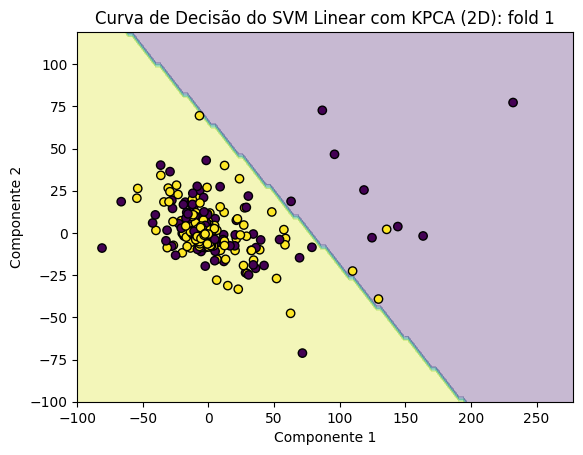

Acurácia no fold 2: 0.52


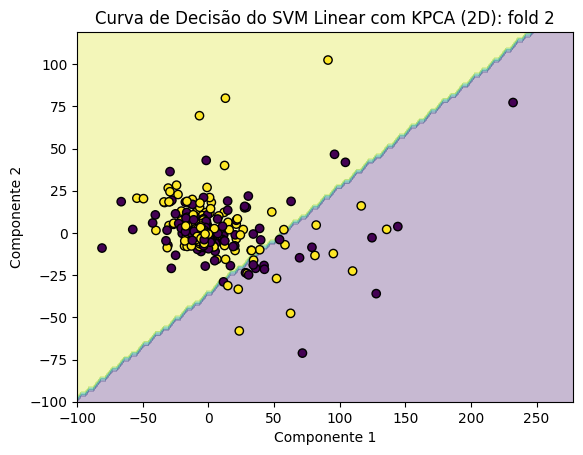

Acurácia no fold 3: 0.47


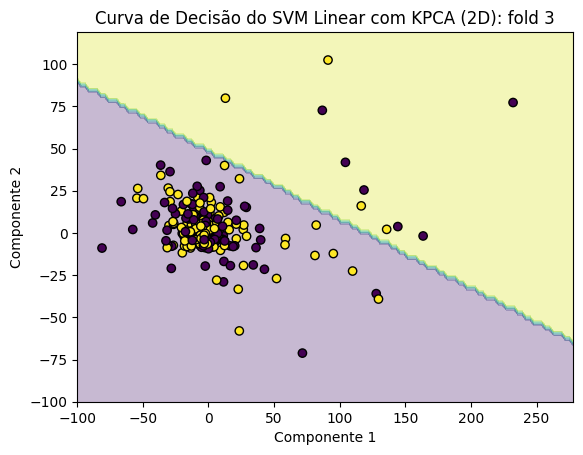

Acurácia no fold 4: 0.48


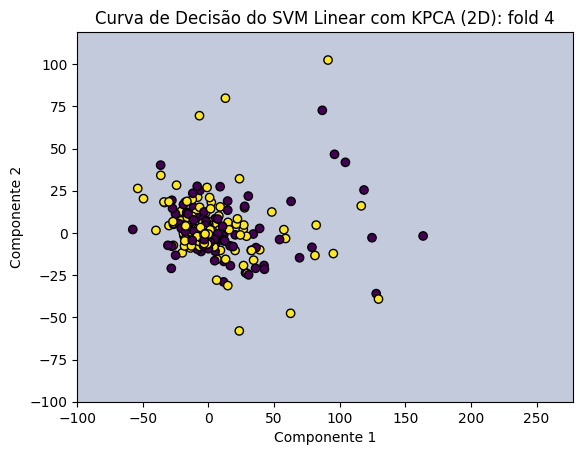

In [67]:
# Usar apenas as duas primeiras componentes principais para plotar
x_train_kpca_2d = x_train_kpca[:, :2]

kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

# Lista para armazenar os modelos
svm_kernel = []

# Contador de folds
fold_number = 1

# Iterar sobre cada fold
for train_index, test_index in kf1.split(x_train_kpca_2d):
    
    X_train_fold, X_val_fold = x_train_kpca_2d[train_index], x_train_kpca_2d[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Criar e treinar o modelo SVM
    clf_kernel = SVC(kernel='linear', C=1.0)
    clf_kernel.fit(X_train_fold, y_train_fold.ravel())

    svm_kernel.append(clf_kernel)
    
    # Avaliar o modelo no conjunto de validação
    accuracy = clf_kernel.score(X_val_fold, y_val_fold)
    print(f"Acurácia no fold {fold_number}: {accuracy:.2f}")

    # Plotar a fronteira de decisão para o fold atual
    plot_decision_boundary(clf_kernel, X_train_fold, y_train_fold, 
                           f'Curva de Decisão do SVM Linear com KPCA (2D): fold {fold_number}', xmin=-100, xmax=280,ymin=-100, ymax=120)
    
    # Incrementar o número do fold
    fold_number += 1

Letra B da questão 1

Aplicando o PCA

In [68]:
pca = PCA(n_components=200)
x_train_pca = pca.fit_transform(x_train_gray_scaled)

In [69]:
# Variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

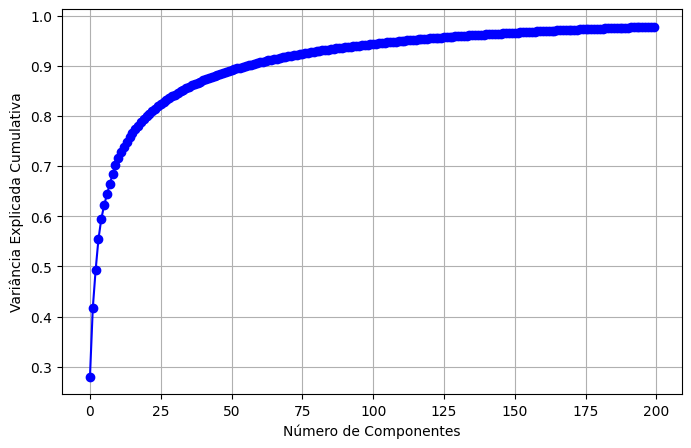

In [70]:
# Plotar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(variancia_explicada_cumulativa, marker='o', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
#plt.title('Gráfico de Variância Explicada Cumulativa por Componentes PCA')
plt.grid()
plt.show()

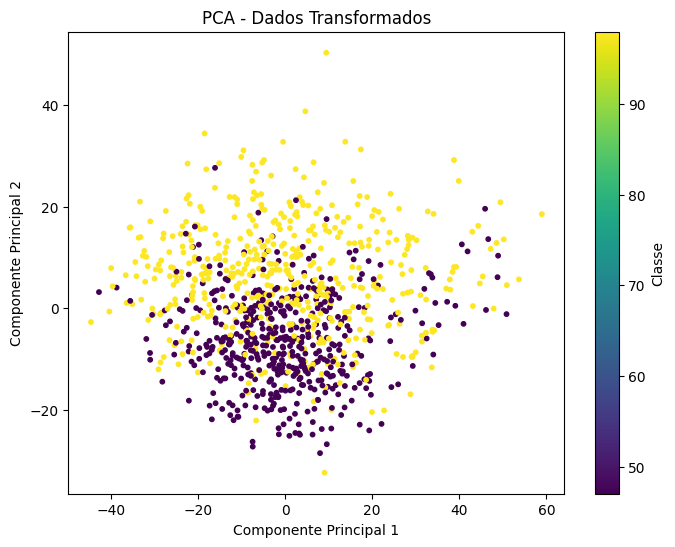

In [71]:
plot_kpca(x_train_pca, y_train, 'PCA - Dados Transformados')

In [72]:
# Por exemplo, manter componentes que explicam pelo menos 95% da variância total
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"Número de componentes principais selecionados: {n_components}")

Número de componentes principais selecionados: 154


Aplicando PCA novamente com o número selecionado de componentes principais

In [73]:
pca_truncated = PCA(n_components=n_components)
X_combined_pca_truncated = pca_truncated.fit_transform(x_train_pca)


# Verificar as shapes após o truncamento
print(f"Shape do X_train após truncamento PCA: {x_train_pca.shape}")


Shape do X_train após truncamento PCA: (1000, 200)


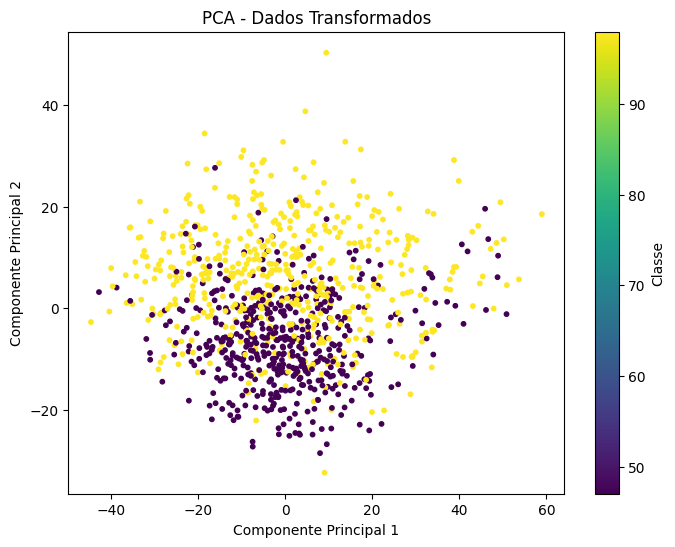

In [76]:
plot_kpca(X_combined_pca_truncated, y_train, 'PCA - Dados Transformados')

Aplicando Kernel SVM

In [79]:
kf2 = KFold(n_splits=4, shuffle=True, random_state=42)

# Lista para armazenar os modelos
svm_kernel = []

# Contador de folds
fold_number = 1

# Iterar sobre cada fold
for train_index, test_index in kf2.split(X_combined_pca_truncated):
    
    X_train_fold, X_val_fold = X_combined_pca_truncated[train_index], X_combined_pca_truncated[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Criar e treinar o modelo SVM
    clf_kernel = SVC(kernel='poly', C=1.0)
    clf_kernel.fit(X_train_fold, y_train_fold.ravel())

    svm_kernel.append(clf_kernel)
    
    # Avaliar o modelo no conjunto de validação
    accuracy = clf_kernel.score(X_val_fold, y_val_fold)
    print(f"Acurácia no fold {fold_number}: {accuracy:.2f}")
    
    # Incrementar o número do fold
    fold_number += 1

Acurácia no fold 1: 0.74
Acurácia no fold 2: 0.77
Acurácia no fold 3: 0.72
Acurácia no fold 4: 0.78


Acurácia no fold 1: 0.69


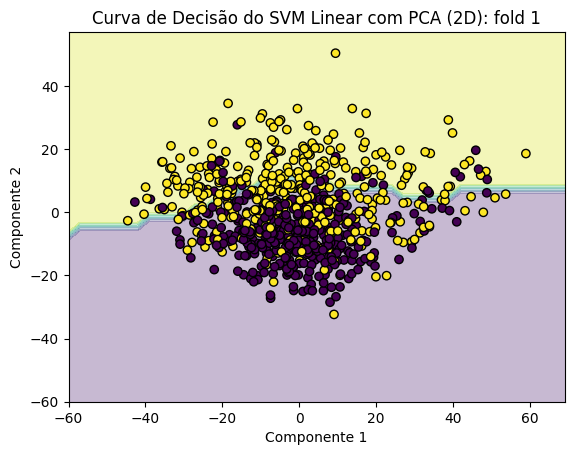

Acurácia no fold 2: 0.70


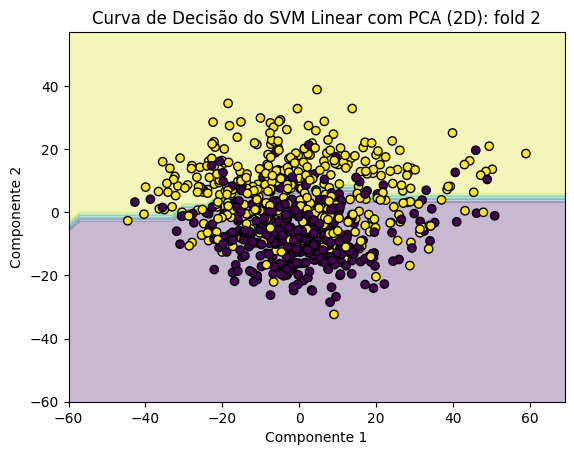

Acurácia no fold 3: 0.69


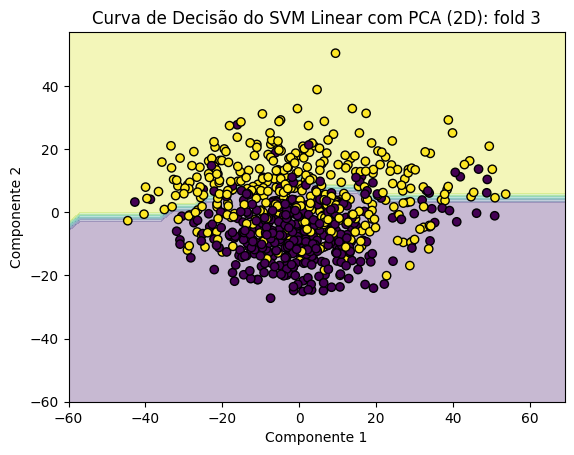

Acurácia no fold 4: 0.72


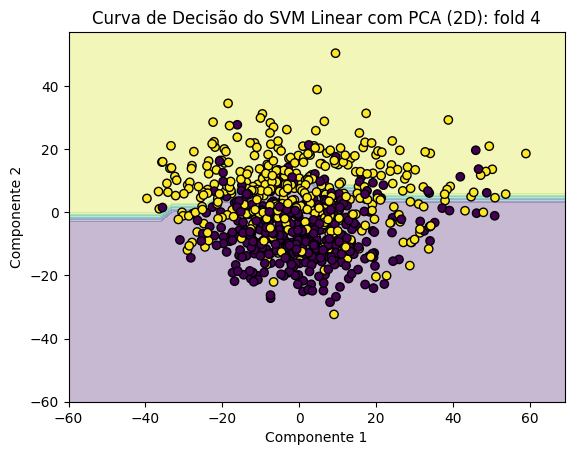

In [80]:
# Usar apenas as duas primeiras componentes principais para plotar
x_train_pca_2d = X_combined_pca_truncated[:, :2]

kf2 = KFold(n_splits=4, shuffle=True, random_state=42)

# Lista para armazenar os modelos
svm_kernel = []

# Contador de folds
fold_number = 1

# Iterar sobre cada fold
for train_index, test_index in kf2.split(x_train_pca_2d):
    
    X_train_fold, X_val_fold = x_train_pca_2d[train_index], x_train_pca_2d[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Criar e treinar o modelo SVM
    clf_kernel = SVC(kernel='poly', C=1.0)
    clf_kernel.fit(X_train_fold, y_train_fold.ravel())

    svm_kernel.append(clf_kernel)
    
    # Avaliar o modelo no conjunto de validação
    accuracy = clf_kernel.score(X_val_fold, y_val_fold)
    print(f"Acurácia no fold {fold_number}: {accuracy:.2f}")

    # Plotar a fronteira de decisão para o fold atual
    plot_decision_boundary(clf_kernel, X_train_fold, y_train_fold, 
                           f'Curva de Decisão do SVM Linear com PCA (2D): fold {fold_number}', xmin=-60, xmax=70,ymin=-60, ymax=60)
    
    # Incrementar o número do fold
    fold_number += 1